# 배깅과 페이스팅 

### 배깅 (Bagging)
배깅(bootstrap aggregation의 줄임말)은 중복을 허용하여 샘플링하는 방식을 말하며, 통계학에서는 부트스트래핑(bootstrapping)이라고 한다.

### 페이스팅 (pasting)
페이스팅은 중복을 허용하지 않고 샘플링 하는 방식을 의미한다.

다음 그림과 같이 배깅과 페이스팅을 이용하면, 하나의 데이터셋에서 여러 개의 서브셋을 통해 같은 알고리즘을 사용한 여러 개의 예측기를 만들 수 있다.(중복을 허용하는 것은 배깅밖에 할 수 없음)

<img src="./images/pasting_and_bagging.png" alt="pasting_and_bagging" width="80%">

위와 같이 여러 개의 예측기를 학습시킨 후에는, **수집 함수(aggregation function)**를 통해 새로운 샘플에 대한 예측을 만들 수 있다. 수집함수는 분류의 경우 통계적 최빈값(statistical mode, 가장 많이 나온 예측(hard voting과 유사함)), 회귀의 경우 평균을 계산한다.

개별 예측기는 원본 훈련세트로 학습시킨 것보다 편향은 크지만, 수집함수를 통과하면 편향과 분산이 모두 감소한다. 따라서, 일반적으로 위와 같은 앙상블의 결과는 **편향은 비슷하지만 분산은 줄어드는 효과**를 얻을 수 있다.

또한, 여러 개의 예측기를 동시에 **병렬로 학습 및 예측을 수행**할 수 있는 장점도 있다.

## 사이킷런의 배깅과 페이스팅

사이킷런에서는 `BaggingClassifier`, `BaggingRegressor`를 통해 배깅과 페이스팅을 사용해 예측기를 훈련시킬 수 있다.(페이스팅의 경우, `bootstrap=False`)

다음은 배깅을 사용한 경우와 사용하지 않은 경우를 비교하는 예이다.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# BaggingClassifier는 사용한 분류기가 확률을 추정할 수 있는 경우,
# predict_proba()도 사용 가능
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)

tree_clf = DecisionTreeClassifier(random_state=42)

In [5]:
from sklearn.metrics import accuracy_score

bag_clf.fit(X_train, y_train)
tree_clf.fit(X_train, y_train)

print(accuracy_score(bag_clf.predict(X_test), y_test))
print(accuracy_score(tree_clf.predict(X_test), y_test))

0.912
0.856


500개의 트리를 사용한 배깅 앙상블 방법이 단일 트리보다 더욱 성능이 좋다는 것을 확인할 수 있다.

결정경계를 그려보면 다음과 같다.

In [8]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

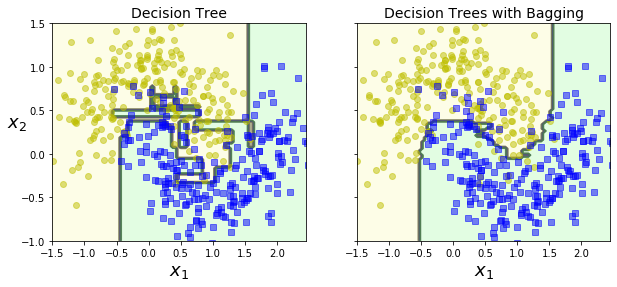

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

배깅의 결정경계가 더욱 규칙적인 것에서, 편향은 비슷하지만 더 작은 분산을 가진다는 것을 확인할 수 있다.

보통은 배깅이 페이스팅보다 편향은 조금 더 높지만 분산을 감소시키기 때문에 더욱 선호된다. 하지만 여유가 있다면 둘 모두를 평가한 후, 더 나은 쪽을 선택하는 것이 좋다.

## oob (out-of-bag) 평가

배깅에서는 평균적으로 약 63%의 훈련 샘플이 각 예측기의 학습에 선택되는데, 선택되지 않은 나머지 37%를 **oob(out-of-bag)** 샘플이라고 한다. 따라서, 별도의 검증세트를 사용하지 않고, **oob 를 통해 성능을 평가**할 수 있다.

사이킷런에서는 `oob_score=True`로 지정하면 훈련이 끝난 후, 자동으로 oob 평가를 수행한다.

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(X_train, y_train)
# oob 평가 점수는 oob_score_ 변수에 저장된다.
print(bag_clf.oob_score_)

0.92


`predict_proba()`를 가지고 있는 예측기로 훈련하였다면, `oob_decision_function_`을 통해 각 oob 샘플에 대한 클래스 확률도 다음과 같이 출력할 수 있다.

In [12]:
print(bag_clf.oob_decision_function_)

[[0.36103896 0.63896104]
 [0.42204301 0.57795699]
 [1.         0.        ]
 [0.01020408 0.98979592]
 [0.02557545 0.97442455]
 [0.10969388 0.89030612]
 [0.39058172 0.60941828]
 [0.07304786 0.92695214]
 [0.93969849 0.06030151]
 [0.80913978 0.19086022]
 [0.54874652 0.45125348]
 [0.04228856 0.95771144]
 [0.72266667 0.27733333]
 [0.83375959 0.16624041]
 [0.92708333 0.07291667]
 [0.09560724 0.90439276]
 [0.02337662 0.97662338]
 [0.91450777 0.08549223]
 [0.65721649 0.34278351]
 [0.94864865 0.05135135]
 [0.05333333 0.94666667]
 [0.23453608 0.76546392]
 [0.9035533  0.0964467 ]
 [1.         0.        ]
 [0.96428571 0.03571429]
 [0.00263852 0.99736148]
 [0.95103093 0.04896907]
 [0.99749373 0.00250627]
 [0.01587302 0.98412698]
 [0.71544715 0.28455285]
 [0.         1.        ]
 [1.         0.        ]
 [0.01025641 0.98974359]
 [0.07552083 0.92447917]
 [0.09973753 0.90026247]
 [0.96632124 0.03367876]
 [0.02284264 0.97715736]
 [0.56847545 0.43152455]
 [0.01036269 0.98963731]
 [0.9974026  0.0025974 ]
